Spark Session web UI: http://10.50.221.197:4040
+--------------------+-----+--------------------+--------------------+
|                flux|label|                name|                time|
+--------------------+-----+--------------------+--------------------+
|[194602.078125, 1...| conf|kplr002581316-201...|[1274.14019845467...|
|[6818722.5, 68190...| conf|kplr003632418-201...|[1274.14035648731...|
|[48374.2421875, 4...| conf|kplr003733628-201...|[1274.14035006258...|
|[86651.015625, 86...| conf|kplr004150804-201...|[1274.14022049512...|
|[12159.1142578125...|   eb|kplr001026032-201...|[1274.14036272274...|
|[96343.7734375, 9...|   eb|kplr001026957-201...|[1274.14035174874...|
|[208676.5625, 208...|   eb|kplr001161345-201...|[1274.14035372128...|
|[3648.109375, 364...|   eb|kplr001432214-201...|[1274.14031962276...|
|[7149.537109375, ...|   fp|kplr000892772-201...|[1274.14036161633...|
|[1170351.625, 117...|   fp|kplr001025986-201...|[1274.14035989129...|
|[36673.83984375, ...|   fp|k

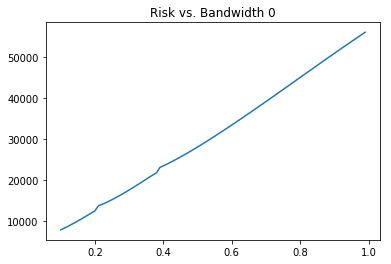

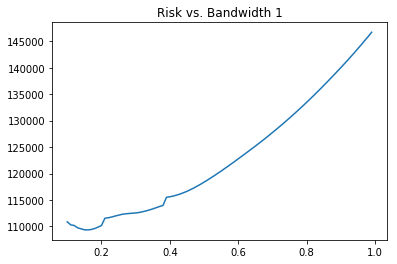

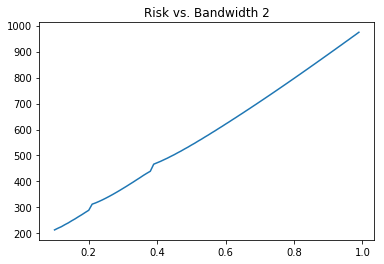

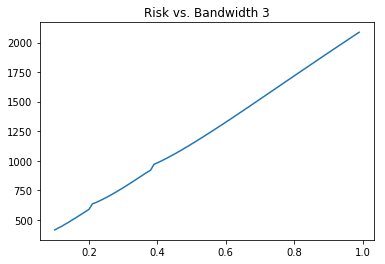

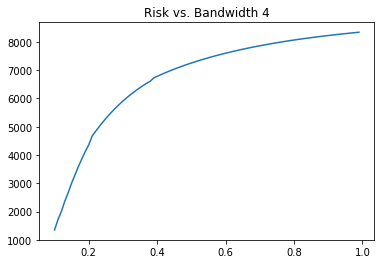

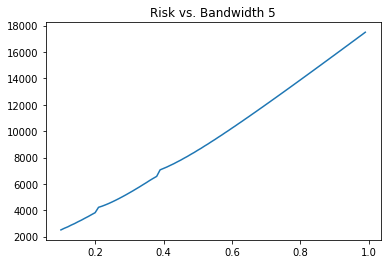

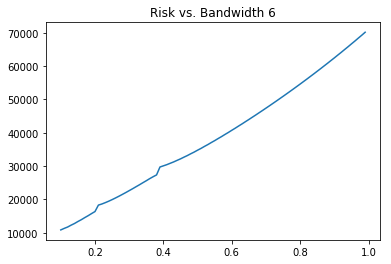

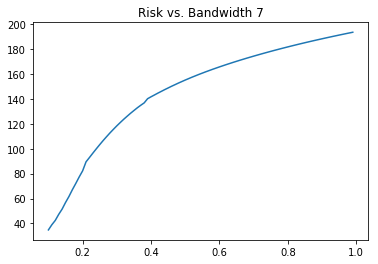

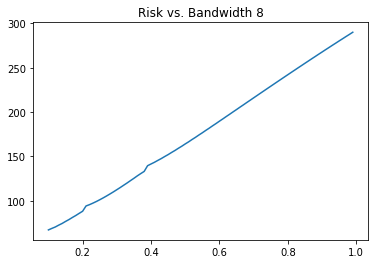

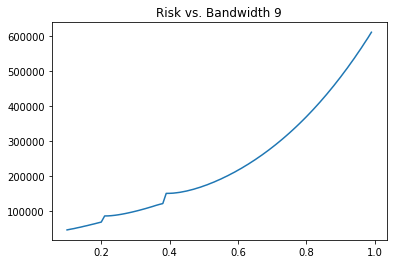

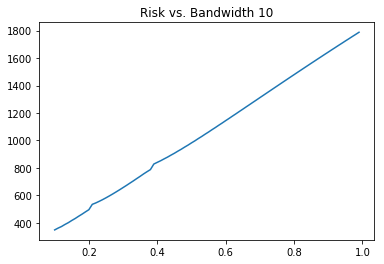

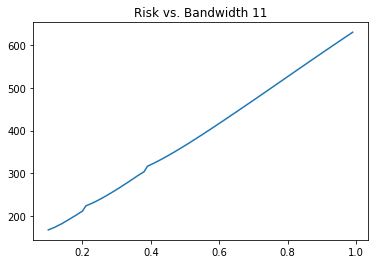

Entering Part B


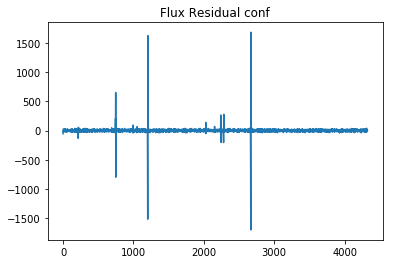

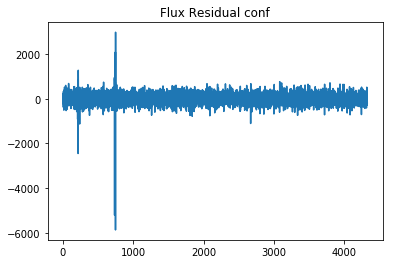

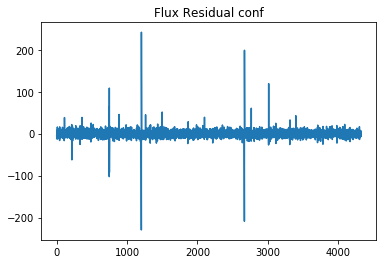

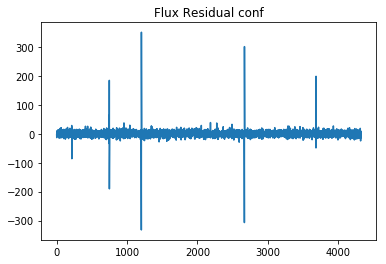

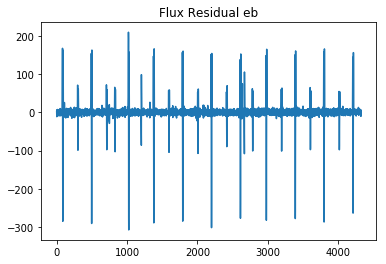

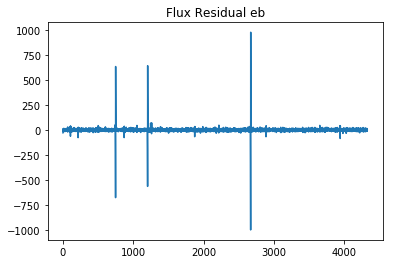

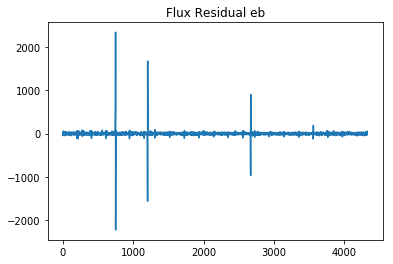

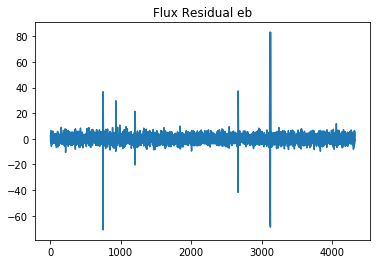

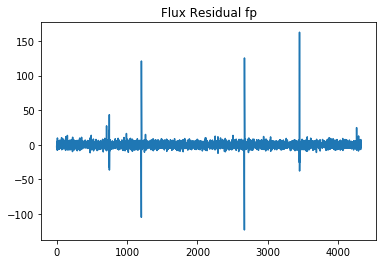

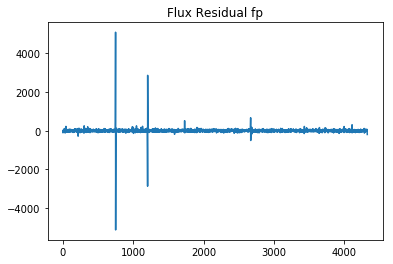

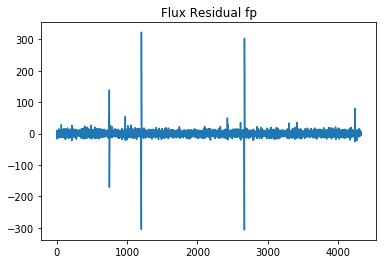

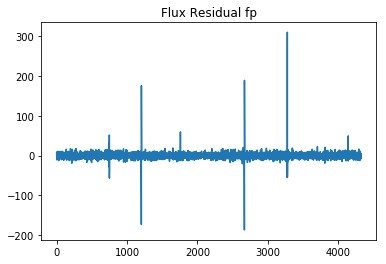

Entering Part C
Thresholding...
Thresholded
Entering Part D


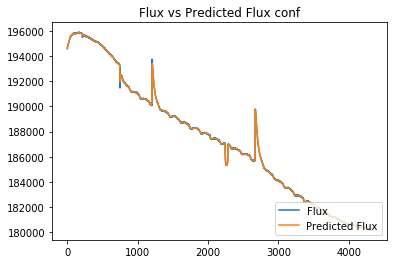

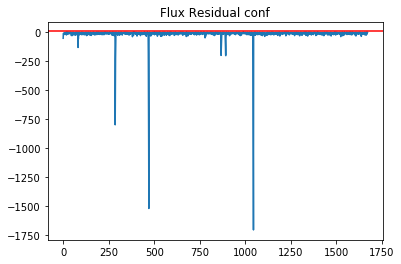

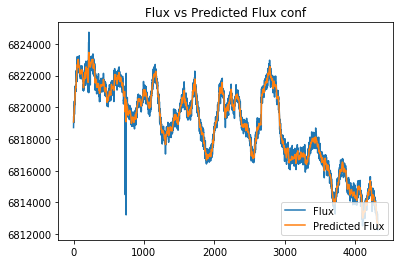

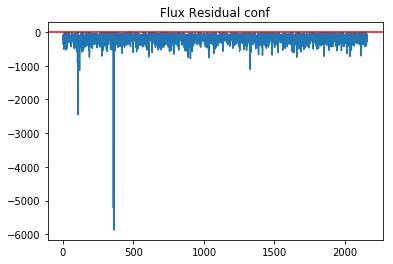

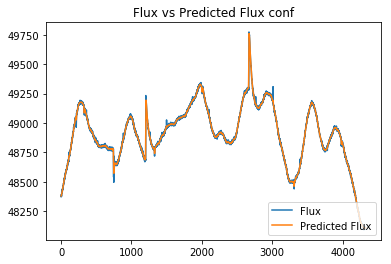

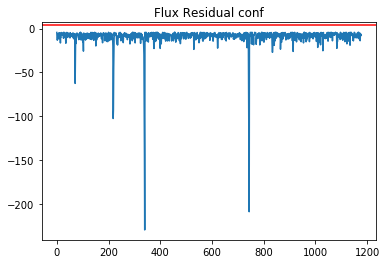

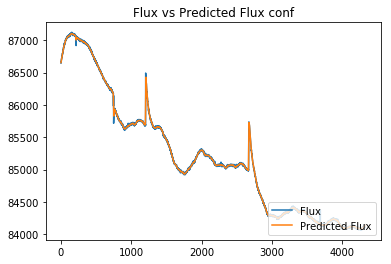

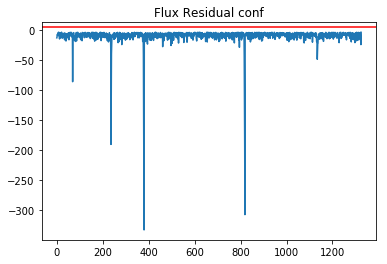

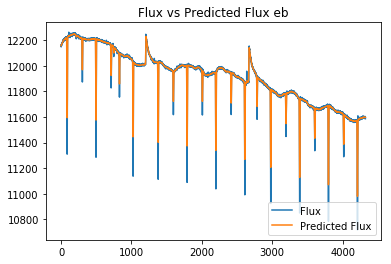

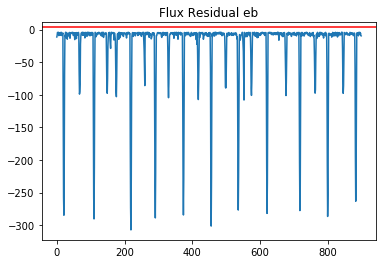

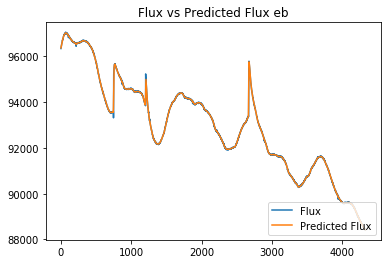

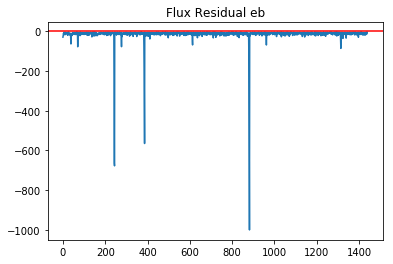

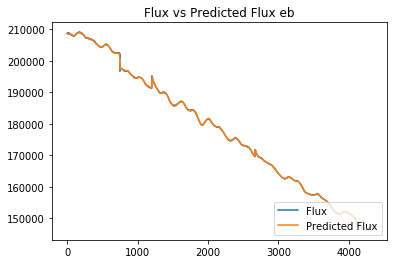

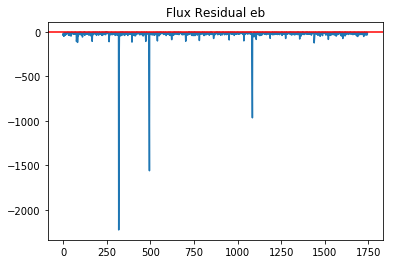

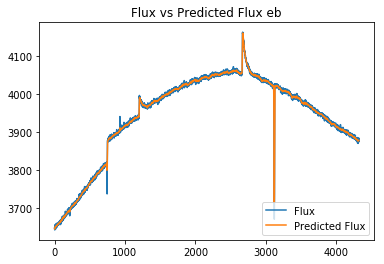

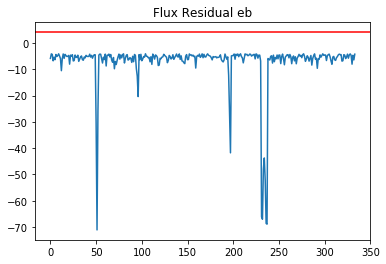

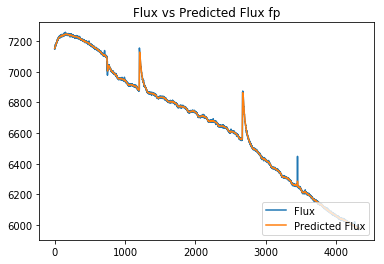

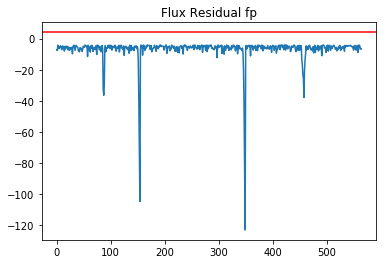

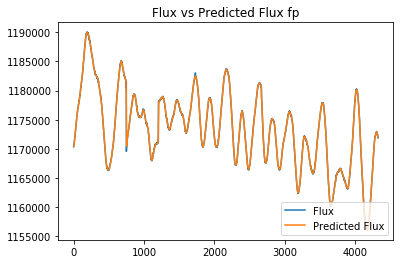

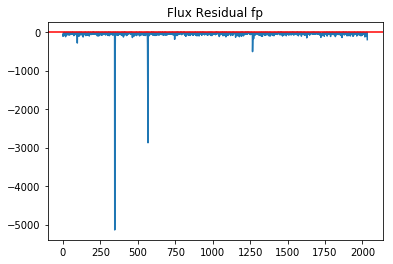

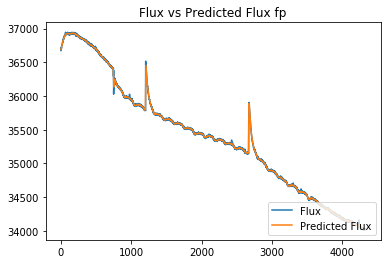

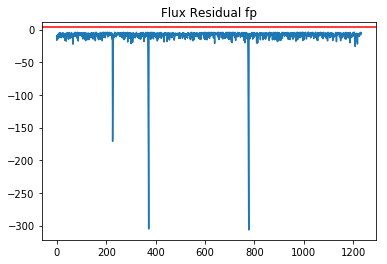

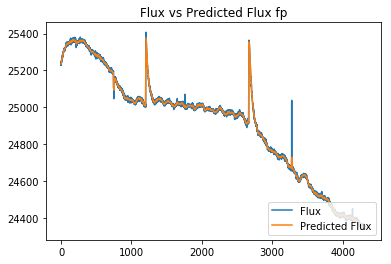

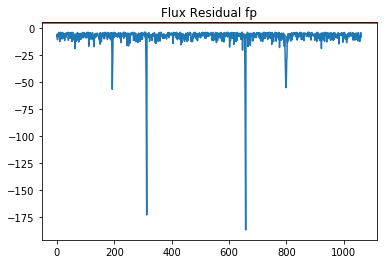

Finished


In [2]:
# Planets
import random
import numpy as np
import scipy
import re
import matplotlib.pyplot as plt
import math
import os
from collections import Counter
from pyspark.sql import SparkSession
from nltk.corpus import stopwords as Stopwords
from pyspark.mllib.linalg import Vectors

# Setup
DATAPATH = '/project/cmsc25025/light_curve/lightcurves-sample.json'

os.system('start-spark-slurm.sh&') # use & to put it into background
ip = os.popen('hostname -i').read().strip('\n')
# change 'local' to be ip of master node
spark = SparkSession.builder\
    .master('spark://' + ip + ':7077')\
    .appName('Spark Try')\
    .getOrCreate()
print 'Spark Session web UI: http://{}:4040'.format(ip)

lc_df = spark.read.json(DATAPATH)

lc_df.show()
flux_set = lc_df.rdd.map(lambda x: x[0]).collect()
label_set = lc_df.rdd.map(lambda x: x[1]).collect()

# Part A
def kernel_epa(scaled_base):
    kernel = (abs(scaled_base) <= 1) * (1 - scaled_base*scaled_base)
    return kernel[kernel > 0]

print "Entering Part A"

# Creating Standardized Time Vector
gap = 0.0204
N = 4757
sz = (N-1)/2
base = np.arange(-gap*sz, gap*(sz+1), gap, dtype=np.float64)
bandwith_range = np.arange(0.1, 1.0, 0.01)

# Testing optimal bandwidth
best_bandwidth = []
error_bandwidth = [[] for x in range(len(flux_set))]

# Removing NaNs from Dataset
new_flux_set = []
base_set = []
for flux in flux_set:
    flux_nan_indices = np.argwhere(np.isnan(flux))
    new_flux_set.append([output for i, output in enumerate(flux) if i not in flux_nan_indices])
    base_set.append([data for i, data in enumerate(base) if i not in flux_nan_indices])
flux_set = new_flux_set[:]

# Cross Validation of Bandwidths
for bandwidth in bandwith_range:
    for flux_index, flux in enumerate(flux_set):
        l_ii = []
        n = len(flux)
        # Calculating model
        weight_vector = kernel_epa(base_set[flux_index]/bandwidth)
        const = np.convolve(weight_vector, np.ones(n, dtype=np.float64), 'same')
        yhat = np.convolve(weight_vector, flux, 'same') / const
        
        risk = 0
        # Utilizing Shortcut Calculation Method
        for i in range(n):
            denominator = 1.0 - (1.0/np.sum(kernel_epa((base_set[flux_index] - base_set[flux_index][i])/bandwidth)))
            risk += ((flux[i] - yhat[i])/denominator)**2
        
        risk = risk/n
        error_bandwidth[flux_index].append((bandwidth, risk))
        
        if len(best_bandwidth) < len(flux_set):
            best_bandwidth.append(bandwidth)
        elif risk < best_bandwidth[flux_index]:
            best_bandwidth[flux_index] = bandwidth

# Plotting Risk
for index, error_vector in enumerate(error_bandwidth):
    plt.clf()
    plt.plot(*zip(*error_vector))
    plt.title('Risk vs. Bandwidth ' + str(index))
    plt.show()


# Part B
print "Entering Part B"
residuals = []
yhat_set = []

# Calculating and Plotting Residuals with Optimal Bandwidths
for index, flux in enumerate(flux_set):
    weight_vector = kernel_epa(base_set[index]/best_bandwidth[index])
    n = len(flux)
    const = np.convolve(weight_vector, np.ones(n, dtype=np.float64), 'same')
    yhat = np.convolve(weight_vector, flux, 'same') / const
    yhat_set.append(yhat)
    residual = np.subtract(flux, yhat)
    residuals.append(residual)
    plt.clf()
    plt.plot(residual)
    plt.title('Flux Residual ' + str(label_set[index]))
    plt.show()

# Part C
def standardize(residual):
    residual_array = np.asarray(residual)
    residual_mean = np.mean(residual_array)
    median = np.median(residual)
    mad = np.median(abs(residual - median))
    theta_hat = 1.4826*mad
    standardized_residual = (residual - residual_mean)/theta_hat
    return standardized_residual

# Standardizing Residuals according to MAD method
print "Entering Part C"
print "Thresholding..."
standardized_residuals = []
for residual in residuals:
    standardized_residuals.append(standardize(residual))
print "Thresholded"

# Part D
# Plotting Thresholded Residuals and Flux v Predicted Flux
print "Entering Part D"
beta = (2 * math.log(len(flux_set[0]))) ** 0.5
threshold_residuals = [[r_i if r_i < (-1 * beta) else 0 for r_i in residual if r_i < (-1 * beta)] for residual in residuals]
for index, flux in enumerate(flux_set):
    plt.clf()
    plt.plot(flux)
    plt.plot(yhat_set[index])
    plt.legend(['Flux', 'Predicted Flux'], loc='lower right')
    plt.title('Flux vs Predicted Flux ' + str(label_set[index]))
    plt.show()

    plt.clf()
    plt.plot(threshold_residuals[index])
    plt.axhline(y=beta, color='r', linestyle='-')
    plt.title('Flux Residual ' + str(label_set[index]))
    plt.show()

print "Finished"
spark.stop()

In [3]:
print "The first and second conf stars resemble confirmed planet stars. The third and fourth conf stars have less predictable flux patterns. The first, second, and third eb stars look like a clear examples of eb systems since they clearly have two periodic dips. The fourth eb star is not as predictable. The fp all resemble the expected fp stars."

The first and second conf stars resemble confirmed planet stars. The third and fourth conf stars have less predictable flux patterns. The first, second, and third eb stars look like a clear examples of eb systems since they clearly have two periodic dips. The fourth eb star is not as predictable. The fp all resemble the expected fp stars.
